In [1]:
# Print python tokenization in detail

import tokenize
import io
import pandas as pd # type: ignore

def tokenize_and_print(code):
    try:
        indent_level = 0
        tokens = tokenize.tokenize(io.BytesIO(code.encode('utf-8')).readline)
        for index, token in enumerate(tokens):
            if index < 1000:
                if token.type == tokenize.NL:
                    indent_level = 0
                elif token.type == tokenize.INDENT:
                    indent_level += 1
                elif token.type == tokenize.DEDENT:
                    indent_level -= 1
            
                print(indent_level, token)
    except tokenize.TokenError:
        print("Tokenization error")

def main():
    filepath = r"C:\Program Files\Coding Programs\GitHub\LLM-Code-Bot\Training_Data\LeetCode_Master\raw_data.csv"
    df = pd.read_csv(filepath)
    target_code = df['targets'].head(3)
    
    for code in target_code:
        tokenize_and_print(code)

if __name__ == '__main__':
    main()


0 TokenInfo(type=67 (ENCODING), string='utf-8', start=(0, 0), end=(0, 0), line='')
0 TokenInfo(type=1 (NAME), string='import', start=(1, 0), end=(1, 6), line='import unittest\n')
0 TokenInfo(type=1 (NAME), string='unittest', start=(1, 7), end=(1, 15), line='import unittest\n')
0 TokenInfo(type=4 (NEWLINE), string='\n', start=(1, 15), end=(1, 16), line='import unittest\n')
0 TokenInfo(type=65 (NL), string='\n', start=(2, 0), end=(2, 1), line='\n')
0 TokenInfo(type=65 (NL), string='\n', start=(3, 0), end=(3, 1), line='\n')
0 TokenInfo(type=1 (NAME), string='class', start=(4, 0), end=(4, 5), line='class ListNode(object):\n')
0 TokenInfo(type=1 (NAME), string='ListNode', start=(4, 6), end=(4, 14), line='class ListNode(object):\n')
0 TokenInfo(type=55 (OP), string='(', start=(4, 14), end=(4, 15), line='class ListNode(object):\n')
0 TokenInfo(type=1 (NAME), string='object', start=(4, 15), end=(4, 21), line='class ListNode(object):\n')
0 TokenInfo(type=55 (OP), string=')', start=(4, 21), end=

In [ ]:
# Raw untokenized code visualization

import pandas as pd
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter

# Load code examples
filepath = r"C:\Program Files\Coding Programs\GitHub\LLM-Code-Bot\Training_Data\LeetCode_Master\raw_data.csv"
df = pd.read_csv(filepath)
targets = df['targets'].head(2)

# Highlight code for each example
formatter = HtmlFormatter(full=True, style='colorful')
html_content = ""
for target in targets:
    highlighted_code = highlight(target, PythonLexer(), formatter)
    display(HTML(highlighted_code))
    
    html_content += highlighted_code + "<br><hr><br>"

# Save colored code to an HTML file
output_html = 'highlighted_code.html'
with open(output_html, 'w') as html_file:
    html_file.write(html_content)


In [18]:
# TESTING CELL

# Compare raw python tokenization to keras tokenization to make sure it stays true

import tokenize
import io
import pandas as pd # type: ignore
from nltk.tokenize import word_tokenize # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore

def tokenize_with_python(code):
    tokens = []
    current_line = None
    try:
        for token in tokenize.generate_tokens(io.StringIO(code).readline):
            # Skip #-based comments (multiline skipped later)
            if token.type == tokenize.COMMENT:
                current_line = token.start[0]
            if current_line and token.start[0] == current_line:
                continue # Skip
            else:
                current_line = None # No longer in a comment

            if token.type == tokenize.STRING:
                string = token.string

                if string.startswith('"""') or string.startswith("'''"):
                    continue # Multi-line comments inflates vocab too much
                
                # Add quotes and content to tokens in order
                tokens.append(string[0])
                tokens.extend(word_tokenize(string[1:-1]))
                tokens.append(string[-1])
            if token.type == tokenize.INDENT:
                tokens.append('<INDENT>')
            elif token.type == tokenize.DEDENT:
                tokens.append('<DEDENT>')
            else:
                tokens.append(token.string)
        
        # Remove extra lines and spaces at the end
        while tokens and tokens[-1] in ('', '<INDENT>', '<DEDENT>'):
            tokens.pop()
    except (tokenize.TokenError, IndentationError) as e:
        pass # Errors counted via compiled_indices
    return tokens

def fit_and_tokenize_with_keras(pre_tokenized_texts, special_tokens):
    tokenizer = Tokenizer(filters='', oov_token='UNK', lower=False)
    tokenizer.fit_on_texts(special_tokens + pre_tokenized_texts)
    sequences = tokenizer.texts_to_sequences(pre_tokenized_texts)
    reverse_word_index = {index: word for word, index in tokenizer.word_index.items()}
    keras_tokens = []
    for seq in sequences[0]:
        keras_tokens.append(reverse_word_index.get(seq, 'UNK'))
    return keras_tokens

def compare_tokenizations(python_tokens, keras_tokens):
    for python_token, keras_token in zip(python_tokens, keras_tokens):
        if python_token != keras_token:
            print(f"Mismatch: {python_token} vs {keras_token}")
            return False
        else:
            print(f"Python: {python_token} | Keras: {keras_token}")

    return True

def main():
    filepath = r"C:\Program Files\Coding Programs\GitHub\LLM-Code-Bot\Training_Data\LeetCode_Master\raw_data.csv"
    df = pd.read_csv(filepath)
    target_code = df['targets'].head(3)

    # Define special tokens
    special_tokens = ['<INDENT>', '<DEDENT>', '\n', ' ' * 4]

    for code in target_code:
        python_tokens = tokenize_with_python(code)
        pre_tokenized_text = ' '.join(python_tokens)
        keras_tokens = fit_and_tokenize_with_keras([pre_tokenized_text], special_tokens)

        if not compare_tokenizations(python_tokens, keras_tokens):
            break

if __name__ == '__main__':
    main()

Python: import | Keras: import
Python: unittest | Keras: unittest
Python: 
 | Keras: 

Python: 
 | Keras: 

Python: 
 | Keras: 

Python: class | Keras: class
Python: ListNode | Keras: ListNode
Python: ( | Keras: (
Python: object | Keras: object
Python: ) | Keras: )
Python: : | Keras: :
Python: 
 | Keras: 

Python: <INDENT> | Keras: <INDENT>
Python: def | Keras: def
Python: __init__ | Keras: __init__
Python: ( | Keras: (
Python: self | Keras: self
Python: , | Keras: ,
Python: x | Keras: x
Python: ) | Keras: )
Python: : | Keras: :
Python: 
 | Keras: 

Python: <INDENT> | Keras: <INDENT>
Python: self | Keras: self
Python: . | Keras: .
Python: val | Keras: val
Python: = | Keras: =
Python: x | Keras: x
Python: 
 | Keras: 

Python: self | Keras: self
Python: . | Keras: .
Python: next | Keras: next
Python: = | Keras: =
Python: None | Keras: None
Python: 
 | Keras: 

Python: 
 | Keras: 

Python: 
 | Keras: 

Python: <DEDENT> | Keras: <DEDENT>
Python: <DEDENT> | Keras: <DEDENT>
Python: class | K

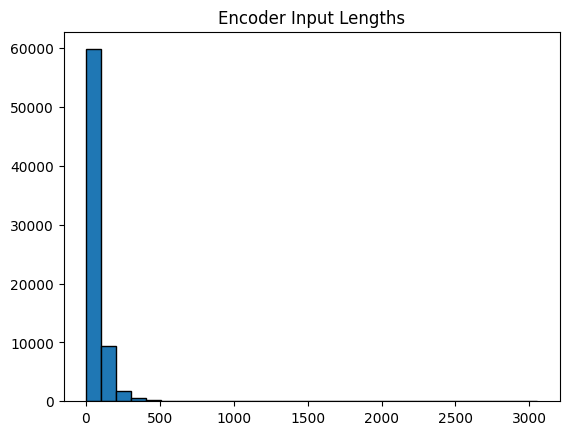

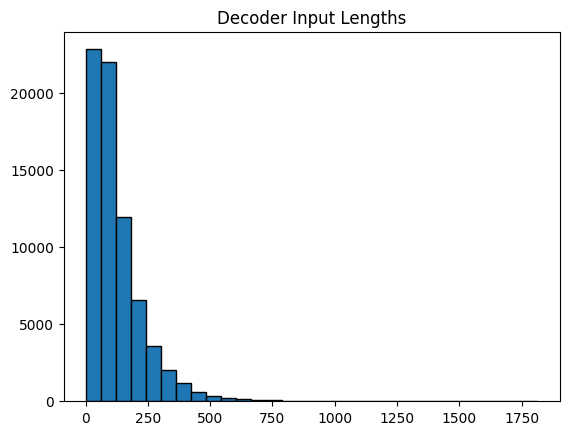

Top 10 Encoder Input Lengths:
Index: 366, Length: 3052
Index: 278, Length: 2227
Index: 353, Length: 2148
Index: 191, Length: 2126
Index: 175, Length: 1941
Index: 215, Length: 1918
Index: 14222, Length: 1824
Index: 219, Length: 1766
Index: 23384, Length: 1709
Index: 21106, Length: 1694

Top 10 Decoder Input Lengths:
Index: 220, Length: 1812
Index: 175, Length: 1763
Index: 174, Length: 1649
Index: 191, Length: 1618
Index: 190, Length: 1540
Index: 327, Length: 1480
Index: 63604, Length: 1449
Index: 392, Length: 1417
Index: 328, Length: 1396
Index: 408, Length: 1392


In [118]:
# Check for unreasonably long encoder_inputs and decoder_inputs

import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

def load_data(npz_path):
    data = np.load(npz_path)
    encoder_inputs = data['encoder_inputs']
    decoder_inputs = data['decoder_inputs']
    return encoder_inputs, decoder_inputs

def plot_histogram(lengths, title):
    plt.hist(lengths, bins=30, edgecolor='black')
    plt.title(title)
    plt.show()

def get_top_indices(lengths, top_n=10):
    length_indices = [(length, idx) for idx, length in enumerate(lengths)]
    length_indices.sort(reverse=True, key=lambda x: x[0])
    return length_indices[:top_n]

def main():
    npz_path = r"C:\Program Files\Coding Programs\GitHub\LLM-Code-Bot\Training_Data\All\tokenized_padded_data.npz"
    encoder_inputs, decoder_inputs = load_data(npz_path)

    # Make histograms
    encoder_lengths = [np.count_nonzero(seq) for seq in encoder_inputs]
    decoder_lengths = [np.count_nonzero(seq) for seq in decoder_inputs]

    plot_histogram(encoder_lengths, 'Encoder Input Lengths')
    plot_histogram(decoder_lengths, 'Decoder Input Lengths')

    # Get the highest indices
    encoder_top_indices = get_top_indices(encoder_lengths)
    decoder_top_indices = get_top_indices(decoder_lengths)
    
    print("Top 10 Encoder Input Lengths:")
    for length, idx in encoder_top_indices:
        print(f"Index: {idx}, Length: {length}")

    print("\nTop 10 Decoder Input Lengths:")
    for length, idx in decoder_top_indices:
        print(f"Index: {idx}, Length: {length}")

if __name__ == "__main__":
    main()


In [3]:
# Test a random string with keras tokenizer

from keras.preprocessing.text import Tokenizer # type: ignore

test_string = '"hello world"'
tokenizer = Tokenizer(filters='', oov_token='UNK', lower=False)
result = tokenizer.texts_to_sequences([test_string])
print(result)

[[None, None]]


In [4]:
import os
import pickle
import numpy as np # type: ignore
from rich.console import Console # type: ignore
from rich.syntax import Syntax # type: ignore

# Set up the console
console = Console()

def load_npz(file_path):
    data = np.load(file_path, allow_pickle=True)
    return data['encoder_inputs'], data['decoder_inputs'], data['targets']

def load_tokenizer(tokenizer_path):
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer

def detokenize(tokenizer, sequences):
    return tokenizer.sequences_to_texts(sequences)

def display_code(code):
    """Display a piece of code with syntax highlighting"""
    syntax = Syntax(code, "python", theme="monokai", line_numbers=True)
    console.print(syntax)

def debug_tokenizer(tokenizer, sequences):
    """Checks vocab, UNK token, and displays a detokenized sequence"""
    word_index = tokenizer.word_index
    print(f"Word index size: {len(word_index)}")
    if "UNK" in word_index:
        print(f"UNK token index: {word_index['UNK']}")
    
    print("Example tokens and their corresponding words:")
    for sequence in sequences[:1]:  # Just checking the first sequence for debug
        for token in sequence:
            if token == 0:
                continue

            for word, index in word_index.items():
                # print(word, index)
                if index == token:
                    print(f"Token: {token}, Word: {word}")
                    break
            else:
                print(f"Token: {token}, Word: UNK")

def main():
    # Set paths
    base_dir = os.getcwd()
    base_dir = os.path.join(base_dir, 'Training_Data', 'All')
    tokenized_data_path = os.path.join(base_dir, 'tokenized_padded_data.npz')
    tokenizer_path = os.path.join(base_dir, 'tokenizer.pkl')

    # Load raw data
    encoder_inputs, decoder_inputs, targets = load_npz(tokenized_data_path)

    # Load tokenizers
    tokenizer = load_tokenizer(tokenizer_path)

    # Debug tokenizers
    print("Tokenizer Debug:")
    debug_tokenizer(tokenizer, encoder_inputs)

    # Detokenize data
    detokenized_problems = detokenize(tokenizer, encoder_inputs[:5])
    detokenized_solutions = detokenize(tokenizer, decoder_inputs[:5])

    # Visualize the data
    for i, (problem, solution) in enumerate(zip(detokenized_problems, detokenized_solutions)):
        print(f"\nExample {i+1} - Problem:\n{'-'*50}")
        display_code(problem)
        print(f"\nExample {i+1} - Solution:\n{'-'*50}")
        display_code(solution)

if __name__ == "__main__":
    main()


Tokenizer Debug:
Word index size: 709337
UNK token index: 1
Example tokens and their corresponding words:
Token: 56793, Word: <SOS>
Token: 1601, Word: Task:
Token: 1483, Word: ---
Token: 1469, Word: Day
Token: 687, Word: 1:
Token: 1584, Word: Not
Token: 88258, Word: Quite
Token: 88259, Word: Lisp
Token: 31799, Word: ---
Santa
Token: 432, Word: was
Token: 48271, Word: hoping
Token: 14, Word: for
Token: 4, Word: a
Token: 2238, Word: white
Token: 22982, Word: Christmas,
Token: 192, Word: but
Token: 1042, Word: his
Token: 2608, Word: weather
Token: 67808, Word: machine's
Token: 120310, Word: "snow"
Token: 48, Word: function
Token: 18, Word: is
Token: 24294, Word: powered
Token: 62, Word: by
Token: 24295, Word: stars,
Token: 9, Word: and
Token: 17524, Word: he's
Token: 5200, Word: fresh
Token: 67809, Word: out!
Token: 406, Word: To
Token: 1904, Word: save
Token: 22982, Word: Christmas,
Token: 999, Word: he
Token: 994, Word: needs
Token: 100, Word: you
Token: 8, Word: to
Token: 2334, Word: c

   1 <SOS> Task: --- Day 1: Not Quite Lisp ---                                                                     
   2 Santa was hoping for a white Christmas, but his weather machine's "snow" function is powered by stars, and he'
   3                                                                                                               
   4 Collect stars by helping Santa solve puzzles. Two puzzles will be made available on each day in the Advent cal
   5                                                                                                               
   6 Here's an easy puzzle to warm you up.                                                                         
   7                                                                                                               
   8 Santa is trying to deliver presents in a large apartment building, but he can't find the right floor - the dir
   9                                                                                                               
  10 An opening parenthesis, (, means he should go up one floor, and a closing parenthesis, ), means he should go d
  11                                                                                                               
  12 The apartment building is very tall, and the basement is very deep; he will never find the top or bottom floor
  13                                                                                                               
  14 For example:                                                                                                  
  15                                                                                                               
  16 (()) and ()() both result in floor 0.                                                                         
  17 ((( and (()(()( both result in floor 3.                                                                       
  18 ))((((( also results in floor 3.                                                                              
  19 ()) and ))( both result in floor -1 (the first basement level).                                               
  20 ))) and )())())[


Example 1 - Solution:
--------------------------------------------------


   1 <SOS> with open("input.txt", "r") as file:                                                                    
   2  data = file.read()                                                                                           
   3                                                                                                               
   4 floor = 0                                                                                                     
   5 for char in data:                                                                                             
   6  if char == "(":                                                                                              
   7  floor += 1                                                                                                   
   8  elif char == ")":                                                                                            
   9  floor -= 1                                                                                                   
  10                                                                                                               
  11 print(floor) UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK U


Example 2 - Problem:
--------------------------------------------------


   1 <SOS> Task: --- Day 1: Not Quite Lisp ---                                                                     
   2 Santa was hoping for a white Christmas, but his weather machine's "snow" function is powered by stars, and he'
   3                                                                                                               
   4 Collect stars by helping Santa solve puzzles. Two puzzles will be made available on each day in the Advent cal
   5                                                                                                               
   6 Here's an easy puzzle to warm you up.                                                                         
   7                                                                                                               
   8 Santa is trying to deliver presents in a large apartment building, but he can't find the right floor - the dir
   9                                                                                                               
  10 An opening parenthesis, (, means he should go up one floor, and a closing parenthesis, ), means he should go d
  11                                                                                                               
  12 The apartment building is very tall, and the basement is very deep; he will never find the top or bottom floor
  13                                                                                                               
  14 For example:                                                                                                  
  15                                                                                                               
  16 (()) and ()() both result in floor 0.                                                                         
  17 ((( and (()(()( both result in floor 3.                                                                       
  18 ))((((( also results in floor 3.                                                                              
  19 ()) and ))( both result in floor -1 (the first basement level).                                               
  20 ))) and )())())[


Example 2 - Solution:
--------------------------------------------------


   1 <SOS> with open('input.txt', 'r') as file:                                                                    
   2  data = file.read()                                                                                           
   3                                                                                                               
   4 floor = 0                                                                                                     
   5 position = 0                                                                                                  
   6                                                                                                               
   7 for char in data:                                                                                             
   8  position += 1                                                                                                
   9  if char == '(':                                                                                              
  10  floor += 1                                                                                                   
  11  elif char == ')':                                                                                            
  12  floor -= 1                                                                                                   
  13  if floor == -1:                                                                                              
  14  break                                                                                                        
  15                                                                                                               
  16 print(position) UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UN


Example 3 - Problem:
--------------------------------------------------


   1 <SOS> Task: --- Day 2: I Was Told There Would Be No Math ---                                                  
   2 The elves are running low on wrapping paper, and so they need to submit an order for more. They have a list of
   3                                                                                                               
   4 Fortunately, every present is a box (a perfect right rectangular prism), which makes calculating the required 
   5                                                                                                               
   6 For example:                                                                                                  
   7                                                                                                               
   8 A present with dimensions 2x3x4 requires 2*6 + 2*12 + 2*8 = 52 square feet of wrapping paper plus 6 square fee
   9 A present with dimensions 1x1x10 requires 2*1 + 2*10 + 2*10 = 42 square feet of wrapping paper plus 1 square f
  10 All numbers in the elves' list are in feet. How many total square feet of wrapping paper should they order?   
  11                                                                                                               
  12 An example part of the input might look like 3x11x24                                                          
  13 13x5x19                                                                                                       
  14 1x9x27                                                                                                        
  15 24x8x21                                                                                                       
  16 6x8x17                                                                                                        
  17 19x18x22                                                                                                      
  18 10x and the answer would be 1588178. UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK U


Example 3 - Solution:
--------------------------------------------------


  1 <SOS> with open('input.txt', 'r') as file:                                                                     
  2  total_paper = 0                                                                                               
  3  for line in file:                                                                                             
  4  l, w, h = map(int, line.strip().split('x'))                                                                   
  5  sides = [l*w, w*h, h*l]                                                                                       
  6  total_paper += 2*sum(sides) + min(sides)                                                                      
  7  print(total_paper) UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK


Example 4 - Problem:
--------------------------------------------------


   1 <SOS> Task: --- Day 2: I Was Told There Would Be No Math ---                                                  
   2 The elves are running low on wrapping paper, and so they need to submit an order for more. They have a list of
   3                                                                                                               
   4 Fortunately, every present is a box (a perfect right rectangular prism), which makes calculating the required 
   5                                                                                                               
   6 For example:                                                                                                  
   7                                                                                                               
   8 A present with dimensions 2x3x4 requires 2*6 + 2*12 + 2*8 = 52 square feet of wrapping paper plus 6 square fee
   9 A present with dimensions 1x1x10 requires 2*1 + 2*10 + 2*10 = 42 square feet of wrapping paper plus 1 square f
  10 All numbers in the elves' list are in feet. How many total square feet of wrapping paper should they order?   
  11                                                                                                               
  12 Your puzzle answer was 1588178.                                                                               
  13                                                                                                               
  14 --- Part Two ---                                                                                              
  15 The elves are also running low on ribbon. Ribbon is all the same width, so they only have to worry about the l
  16                                                                                                               
  17 The ribbon required to wrap a present is the shortest distance around its sides, or the smallest perimeter of 
[1;38;2;227;227;221;48;


Example 4 - Solution:
--------------------------------------------------


   1 <SOS> total_paper = 0                                                                                         
   2 total_ribbon = 0                                                                                              
   3                                                                                                               
   4 with open("input.txt") as f:                                                                                  
   5  for line in f:                                                                                               
   6  l, w, h = map(int, line.strip().split('x'))                                                                  
   7  sides = [l*w, w*h, h*l]                                                                                      
   8  total_paper += 2*sum(sides) + min(sides)                                                                     
   9  total_ribbon += 2*min(l+w, w+h, h+l) + l*w*h                                                                 
  10                                                                                                               
  11 print(total_paper)                                                                                            
  12 print(total_ribbon) UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UN


Example 5 - Problem:
--------------------------------------------------


   1 <SOS> Task: --- Day 3: Perfectly Spherical Houses in a Vacuum ---                                             
   2 Santa is delivering presents to an infinite two-dimensional grid of houses.                                   
   3                                                                                                               
   4 He begins by delivering a present to the house at his starting location, and then an elf at the North Pole cal
   5                                                                                                               
   6 However, the elf back at the north pole has had a little too much eggnog, and so his directions are a little o
   7                                                                                                               
   8 For example:                                                                                                  
   9                                                                                                               
  10 > delivers presents to 2 houses: one at the starting location, and one to the east.                           
  11 ^>v< delivers presents to 4 houses in a square, including twice to the house at his starting/ending location. 
  12 ^v^v^v^v^v delivers a bunch of presents to some very lucky children at only 2 houses.                         
  13                                                                                                               
  14 An example part of the input might look like ^^<<v<<v><v^^<><>^^<v<v^>>^^^><^>v^>v><><><<vv^^<^ and the answer


Example 5 - Solution:
--------------------------------------------------


   1 <SOS> with open('input.txt', 'r') as file:                                                                    
   2  directions = file.read()                                                                                     
   3                                                                                                               
   4 houses = set()                                                                                                
   5 x, y = 0, 0                                                                                                   
   6 houses.add((x, y))                                                                                            
   7                                                                                                               
   8 for direction in directions:                                                                                  
   9  if direction == '^':                                                                                         
  10  y += 1                                                                                                       
  11  elif direction == 'v':                                                                                       
  12  y -= 1                                                                                                       
  13  elif direction == '>':                                                                                       
  14  x += 1                                                                                                       
  15  elif direction == '<':                                                                                       
  16  x -= 1                                                                                                       
  17  houses.add((x, y))                                                                                           
  18                                                                                                               
  19 print(len(houses)) UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK

In [8]:
import re
from langdetect import detect, DetectorFactory
import langdetect.lang_detect_exception

# Fix the seed for language detection to make it deterministic
DetectorFactory.seed = 0

def remove_non_english_comments(code):
    """Remove comments in languages other than English without leaving gaps."""
    def is_english(text):
        try:
            return detect(text) == 'en'
        except langdetect.lang_detect_exception.LangDetectException:
            return False

    # Regex to match comments (both single-line and multi-line)
    single_line_comment_pattern = re.compile(r'#.*$', re.MULTILINE)
    multi_line_comment_pattern = re.compile(r'\'\'\'.*?\'\'\'|\"\"\".*?\"\"\"', re.DOTALL)

    def replace_single_line_comment(match):
        comment = match.group(0)
        if is_english(comment):
            return comment
        return ''  # Remove non-English single-line comment

    def replace_multi_line_comment(match):
        comment = match.group(0)
        if is_english(comment):
            return comment
        return ''  # Remove non-English multi-line comment

    # Remove non-English comments
    code = re.sub(single_line_comment_pattern, replace_single_line_comment, code)
    code = re.sub(multi_line_comment_pattern, replace_multi_line_comment, code)

    # Remove any lines that are now empty or contain only whitespace
    code = "\n".join(line for line in code.splitlines() if line.strip())

    return code

# Example usage
code = """
def example():
    # This is an English comment
    print("Hello, world!")
    # 这是一个中文评论
    '''Multi-line comment in English
    Still in English'''
    '''多行评论中文'''
    print("Goodbye, world!")
"""

cleaned_code = remove_non_english_comments(code)
print(cleaned_code)


def example():
    # This is an English comment
    print("Hello, world!")
    '''Multi-line comment in English
    Still in English'''
    print("Goodbye, world!")


In [32]:
from unidecode import unidecode

# Example text with the Greek letter lambda (λ)
text = "\u20ac"

# Convert to plain ASCII
cleaned_text = unidecode(text)

print("Original text:", text)
print("Cleaned text:", cleaned_text)


Original text: â
Cleaned text: a
